<a href="https://colab.research.google.com/github/zhiyangg/aps360/blob/main/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Old Baseline Model: ResNet18

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import time
import matplotlib.pyplot as plt

In [ ]:
def get_accuracy(model, data):
    correct = 0
    total = 0
    model.eval()

    for imgs, labels in DataLoader(data, batch_size=64):
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

    return correct / total

In [ ]:
# Code from tutorial 3
def train(model, train_data, valid_data, batch_size=64, num_epochs=1):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True) # shuffle after every epoch

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        for imgs, labels in iter(train_loader):

            #############################################
            #To Enable GPU Usage
            if torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            #############################################

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            ##### Mini_batch Accuracy #####              We don't compute accuracy on the whole training set in every iteration!
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            Mini_batch_total = imgs.shape[0]
            train_acc.append((mini_batch_correct / Mini_batch_total))
            ###############################

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy(model, valid_data))  # compute validation accuracy
            n += 1
            mini_b += 1
            # print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))

        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))

    end_time= time.time()

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy(model, train_data))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))


In [ ]:
base_model = models.resnet18(weights="DEFAULT")
num_features = base_model.fc.in_features
base_model.fc = nn.Linear(num_features, 2)

if torch.cuda.is_available():
    base_model.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

train(base_model, [], [])

### Loading Data Remote

In [ ]:
! pip install wget

In [ ]:
!wget 'https://github.com/raymanhuang/aps360data/raw/main/Dataset.zip' -O Kaggle_Dataset.zip

In [ ]:
!unzip 'Kaggle_Dataset.zip' -d '/root/datasets'

### Loading Data Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Upload Data.zip into Colab Notebooks folder in google drive

In [ ]:
!unzip '/content/drive/My Drive/Colab Notebooks/Data.zip' -d '/root/datasets'

### Splitting Data

In [4]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [44]:
baseline_transform = transforms.Compose(
        [transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = ImageFolder('/root/datasets/Dataset/train', transform=baseline_transform)
val_data = ImageFolder('/root/datasets/Dataset/val', transform=baseline_transform)

### New Baseline Code:


In [ ]:
def train_resnet(model, train_loader, valid_loader, lr=0.001, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        train_losses.append(total_train_loss / len(train_loader))

        model.eval()  # Set model to evaluation mode
        total_valid_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_valid_loss += loss.item()
        valid_losses.append(total_valid_loss / len(valid_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}")

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.title('Epoch vs. Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
resnet_weights = models.ResNet18_Weights.DEFAULT
base_model = models.resnet18(weights=resnet_weights)
resnet_transforms = resnet_weights.transforms()

base_model

In [ ]:
# Initialize model
resnet_weights = models.ResNet18_Weights.DEFAULT
base_model = models.resnet18(weights=resnet_weights)
resnet_transforms = resnet_weights.transforms()

base_model

# Modify classification layer
num_features = base_model.fc.in_features
base_model.fc = nn.Linear(num_features, 3)  # 3 output classification

# Freeze weights of convolution layers
resnet_features = nn.Sequential(*(list(base_model.children())[0:8]))
for param in resnet_features.parameters():
    param.requires_grad = False

# Load the dataset
train_dataset = ImageFolder(root='path_to_train_dataset', transform=resnet_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = ImageFolder(root='path_to_valid_dataset', transform=resnet_transforms)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Enable GPU usage
if torch.cuda.is_available():
    base_model.cuda()

# Call training function


# Simple CNN Baseline Model

In [21]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time

In [32]:
class Simple_CNN(nn.Module):
    def __init__(self):
        super(Simple_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3) #in_channels, out_chanels, kernel_size
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride
        self.fc1 = nn.Linear(16 * 54 * 54, 64)
        self.fc2 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 54 * 54)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        imgs = imgs.cuda()
        labels = labels.cuda()

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [57]:
def get_val_performance(model, data_loader):
    correct = 0
    total = 0
    avg_loss = 0.0
    it = 0
    criterion = nn.CrossEntropyLoss()

    for imgs, labels in data_loader:
        imgs = imgs.cuda()
        labels = labels.cuda()

        output = model(imgs)
        loss = criterion(output, labels)
        avg_loss += loss.item()
        it += 1

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

    accuracy = correct / total
    loss = float(avg_loss) / it

    return accuracy, loss

In [62]:
def train_net(model, batch_size, learning_rate, num_epochs):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, train_loss, val_loss , train_acc, val_acc = [], [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        avg_loss = 0.0
        it = 0
        for imgs, labels in train_loader:
            imgs = imgs.cuda()
            labels = labels.cuda()

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            ##### Mini_batch Accuracy ##### We don't compute accuracy on the whole training set in every iteration!
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            Mini_batch_total = imgs.shape[0]
            train_acc.append((mini_batch_correct / Mini_batch_total))
            ###########################

            # save the current training information
            iters.append(n)
            train_loss.append(float(loss))
            va, vl = get_val_performance(model, val_loader)
            val_acc.append(va)
            val_loss.append(vl)
            n += 1
            mini_b += 1
            print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))

        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))

    end_time= time.time()

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.plot(iters, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy(model, train_loader))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))

Iteration:  1 Progress:   1.00  % Time Elapsed:   4.48 s 
Iteration:  2 Progress:   2.00  % Time Elapsed:   8.97 s 
Iteration:  3 Progress:   3.00  % Time Elapsed:  14.03 s 
Iteration:  4 Progress:   4.00  % Time Elapsed:  18.54 s 
Iteration:  5 Progress:   5.00  % Time Elapsed:  23.56 s 
Iteration:  6 Progress:   6.00  % Time Elapsed:  28.23 s 
Iteration:  7 Progress:   7.00  % Time Elapsed:  32.66 s 
Iteration:  8 Progress:   8.00  % Time Elapsed:  37.79 s 
Iteration:  9 Progress:   9.00  % Time Elapsed:  42.29 s 
Iteration:  10 Progress:  10.00  % Time Elapsed:  46.91 s 
Iteration:  11 Progress:  11.00  % Time Elapsed:  51.77 s 
Iteration:  12 Progress:  12.00  % Time Elapsed:  56.30 s 
Iteration:  13 Progress:  13.00  % Time Elapsed:  61.41 s 
Iteration:  14 Progress:  14.00  % Time Elapsed:  65.91 s 
Iteration:  15 Progress:  15.00  % Time Elapsed:  70.41 s 
Iteration:  16 Progress:  16.00  % Time Elapsed:  75.66 s 
Iteration:  17 Progress:  17.00  % Time Elapsed:  80.16 s 
Iterat

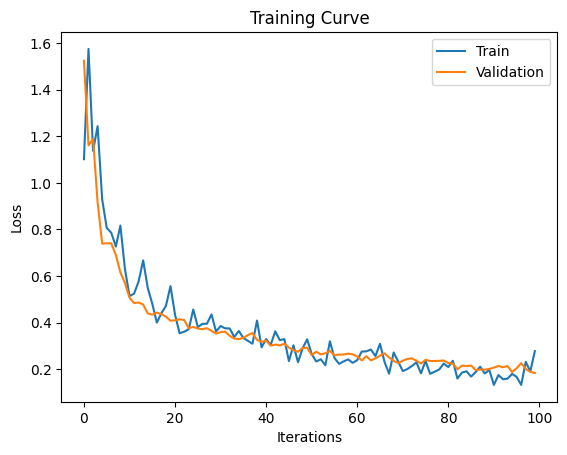

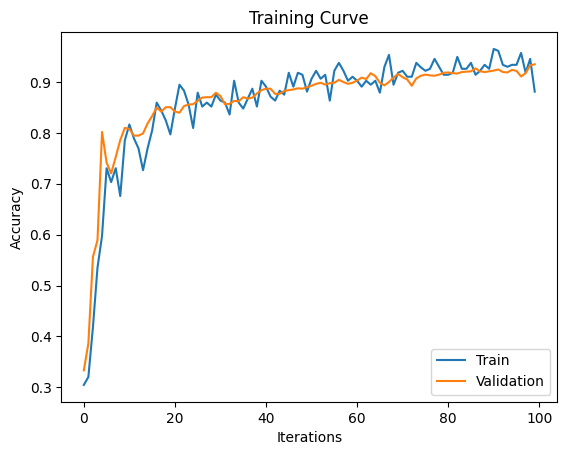

Final Training Accuracy: 0.9555234425176622
Final Validation Accuracy: 0.934640522875817
Total time:   470.95 s  Time per Epoch:  117.74 s 


In [63]:
base_model = Simple_CNN()
base_model.cuda()
train_net(base_model, 256, 0.001, 4)